# "Телеком — поиск клиента с неоптимальными тарифами"

# Содержание:
1. [Описание проекта](#step1)
2. [Шаг 1. Получение и предобработка данных](#step2)
3. [Шаг 2. Исследовательский анализ данных](#step3)
4. [Шаг 3. Исследование изменений тарифов у пользователей](#step4)
5. [Шаг 4. Проверка гипотез](#step5)
6. [Шаг 5. Формирование выводов и предположение оптимизации потерь компании](#step6)
7. [Материалы](#step7)

# Описание проекта:<a id="step1"></a>   
</div>

Компания "Телеком" занимается предоставлением услуг виртуальной телефонии. Клиентами являются организации, которым нужно распределить множество входящих вызовов на различных операторов, либо осуществлять исходящие вызовы силами операторов. Также операторы могут осуществлять внутренние вызовы, то есть вызовы друг между другом, которые осуществляются внутри сети виртуальной телефонии.

На данный рынок приходит новый участник. Заказчик проекта - исполнительный директор компании "Телеком" - хочет выяснить, каким образом можно удержать клиентов от возможного перехода к другому оператору. В дальнейшем полученные данные он передаст менеджерам по работе с клиентами.

# План действий:
1. Импортируем библиотеки, загрузим файлы данных, изучим их.
2. Проведем обработку данных: изучим пропущенные значения, типы данных в колонках, названия колонок, поиск дубликатов, поиск аномалий и выбросов.
3. Проведем исследовательский анализ данных: определим количество активных клиентов, количество клиентов на каждом тарифе, их средние траты на тариф. Определим доходы с каждого тарифа. Подберем оптимальный тариф для активных клиентов и сделаем анализ неоптимального использования тарифов клиентами.
4. Посчитаем, как изменится выручка, если всех активных пользователей перевести на оптимальные для них тарифы и как изменится выручка, если перевести на оптимальные тарифы не всех пользователей, а только тех, для кого разница в оплате будет существенной.
5. Проверим гипотезы.
6. Сформируем выводы и предположения оптимизации потерь компании

# Шаг 1. Получение и предобработка данных:<a id="step2"></a>   
</div>

In [1]:
# Импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)
from datetime import datetime, timezone
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Сохранение файла в переменные
df = pd.read_csv('D:/Project/12/telecom_dataset.csv', sep=',') 
df_clients = pd.read_csv('D:/Project/12/telecom_clients.csv', sep=',')

In [3]:
# Посмотрим размер первого датафрейма
df.shape

(53902, 9)

In [4]:
# Посмотрим размер второго датафрейма
df_clients.shape

(732, 3)

В первом датафрейме 9 колонок и 53902 строки, во втором датафрейме 3 колонки и 732 строки

In [5]:
# Выведем первые 5 строк первого файла
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,"880,022.00",True,3,0,25


In [6]:
# Посмотрим общую информацию о первом файле
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


#### Значения колонок датафрейма `df`:
- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

In [7]:
# Выведем первые 5 строк второго файла
df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [8]:
# Посмотрим общую информацию о втором файле
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


#### Значения колонок датафрейма `df_clients`:
- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

#### Вывод по шагу 1:
1. Библиотеки импортированы.
2. Данные загружены, названия колонок согласно документации, требуется обработка данных

# Шаг 2. Исследовательский анализ данных:<a id="step3"></a>   
</div>

#### Обработка пропущенных значений:

Еще раз посмотримобщую информацию о первом датафрейме:

In [9]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,"880,022.00",True,3,0,25


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Как видим, пропуски содержатся в колонке `operator_id` ("Идентификатор оператора") и `internal` ("Маркер внутренних и внешних вызовов").

Посчитаем проценты пропущенных значений в колонках:

In [11]:
# Посчитаем процент пропущенных значений для колонки `internal` ("Маркер внутренних и внешних вызовов")
df['internal'].isnull().sum()/len(df) * 100

0.21706059144373122

Получается, пропущенных значений меньше 1%, что означает статистическую погрешность. Следовательно, мы можем удалить эти строки - это никак не повлияет на наши дальнейшие расчеты.

In [12]:
# Для удаления строк с неизвестными применяется метод `dropna()`. Дополнительно указывается параметр `subset`,
# которому передается столбец, где он должен искать пропуски
df.dropna(subset=['internal'], axis=0, inplace=True)

In [13]:
# Проверка датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53785 non-null  int64  
 1   date                 53785 non-null  object 
 2   direction            53785 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       53785 non-null  bool   
 6   calls_count          53785 non-null  int64  
 7   call_duration        53785 non-null  int64  
 8   total_call_duration  53785 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


Посмотрим на процент в следующей колонке:

In [14]:
# Посчитаем процент пропущенных значений для колонки `operator_id` ("Идентификатор оператора")
df['operator_id'].isnull().sum()/len(df) * 100

15.087849772241333

Получили 15% пропущенных значений. Удалять нельзя, так как это большое количество и удаление этих данных может привести к искажению результатов нашей работы. Рассмотрим пропущенные значения более внимательно:

In [15]:
# Создадим переменную только с пропущенными значениями в колонке `operator_id`
operator_id_isna = pd.isna(df['operator_id'])
operator_id_isna = df[operator_id_isna]
operator_id_isna

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


In [16]:
# Пройдемся циклом по всем колонкам, посмотрм данные в них
for column in operator_id_isna.columns.values.tolist():
    display(column)
    display(operator_id_isna[column].value_counts())
    display(2*'--------------------------')

'user_id'

168252    145
166405    120
166582    118
166782    117
166658    111
         ... 
168010      1
167139      1
166507      1
166554      1
168013      1
Name: user_id, Length: 305, dtype: int64

'----------------------------------------------------'

'date'

2019-10-28 00:00:00+03:00    141
2019-11-25 00:00:00+03:00    135
2019-11-28 00:00:00+03:00    135
2019-11-20 00:00:00+03:00    135
2019-11-26 00:00:00+03:00    134
                            ... 
2019-08-10 00:00:00+03:00      3
2019-08-03 00:00:00+03:00      3
2019-08-11 00:00:00+03:00      2
2019-08-02 00:00:00+03:00      2
2019-08-04 00:00:00+03:00      1
Name: date, Length: 119, dtype: int64

'----------------------------------------------------'

'direction'

in     7917
out     198
Name: direction, dtype: int64

'----------------------------------------------------'

'internal'

False    7760
True      355
Name: internal, dtype: int64

'----------------------------------------------------'

'operator_id'

Series([], Name: operator_id, dtype: int64)

'----------------------------------------------------'

'is_missed_call'

True     7993
False     122
Name: is_missed_call, dtype: int64

'----------------------------------------------------'

'calls_count'

1       2789
2       1339
3        805
4        511
5        328
        ... 
1914       1
1411       1
536        1
1115       1
91         1
Name: calls_count, Length: 197, dtype: int64

'----------------------------------------------------'

'call_duration'

0        7993
229         3
49          2
170         2
26175       2
         ... 
2059        1
6320        1
81          1
1195        1
169         1
Name: call_duration, Length: 110, dtype: int64

'----------------------------------------------------'

'total_call_duration'

2       598
0       361
4       264
1       259
6       194
       ... 
1240      1
298       1
258       1
451       1
281       1
Name: total_call_duration, Length: 969, dtype: int64

'----------------------------------------------------'

Видно, что несмотря на пропущенные значения, остальные данные в строках имеются. Причем какой-то закономерности не наблюдается. Следовательно, это подтверждает нашу версию о том, что удалять эти данные нельзя, поэтому оставим их

Рассмотрим второй датафрейм `df_clients`:

In [17]:
df_clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

Пропущенных значений нет

#### Обработка типов данных в колонках:

In [18]:
df.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",True,1,0,1


In [19]:
df_clients.head(3)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


Необходимо поменять тип колонки `date` и `date_start`:

In [20]:
# Обработаем столбец `date`:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.tz_localize(None)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53785 non-null  int64         
 1   date                 53785 non-null  datetime64[ns]
 2   direction            53785 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45670 non-null  float64       
 5   is_missed_call       53785 non-null  bool          
 6   calls_count          53785 non-null  int64         
 7   call_duration        53785 non-null  int64         
 8   total_call_duration  53785 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.7+ MB


In [22]:
# Обработаем столбец `date`:
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'], format='%Y-%m-%d').dt.tz_localize(None)

In [23]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [24]:
operator_id_isna['date'] = pd.to_datetime(operator_id_isna['date'], format='%Y-%m-%d').dt.tz_localize(None)

In [25]:
operator_id_isna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8115 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              8115 non-null   int64         
 1   date                 8115 non-null   datetime64[ns]
 2   direction            8115 non-null   object        
 3   internal             8115 non-null   object        
 4   operator_id          0 non-null      float64       
 5   is_missed_call       8115 non-null   bool          
 6   calls_count          8115 non-null   int64         
 7   call_duration        8115 non-null   int64         
 8   total_call_duration  8115 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 578.5+ KB


Остальные типы данных в обработке не нуждаются

#### Обработка названий колонок:

In [26]:
df.columns

Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

In [27]:
df_clients.columns

Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')

Колонки написаны в нижнем регистре, понятны, поэтому в обработке не нуждаются

#### Поиск дубликатов:

In [28]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05,out,False,"880,022.00",True,3,0,25


In [29]:
# Проверка первого датафрейма на дубликаты
df.duplicated().sum()

4893

In [30]:
# Проверка второго датафрейма на дубликаты
df_clients.duplicated().sum()

0

В первом датафрейме очень много дубликатов. Рассмотрим их чуть внимательнее:

In [31]:
# Выведем первые 10 строчек с дубликатами
df[df.duplicated(keep=False)].head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,out,False,"880,020.00",True,8,0,50
8,166377,2019-08-05,out,False,"880,020.00",True,8,0,50
27,166377,2019-08-12,in,False,NaN,True,2,0,34
28,166377,2019-08-12,in,False,NaN,True,2,0,34
38,166377,2019-08-14,in,False,NaN,True,1,0,3
43,166377,2019-08-14,out,False,"880,026.00",False,10,1567,1654
44,166377,2019-08-14,out,False,"880,026.00",False,10,1567,1654
45,166377,2019-08-14,in,False,NaN,True,1,0,3
46,166377,2019-08-15,out,False,"880,026.00",False,11,1413,1473
51,166377,2019-08-15,out,False,"880,026.00",False,11,1413,1473


In [32]:
# Выведем строчки с индексами от 5 до 8
df.iloc[5:9]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
5,166377,2019-08-05,out,False,"880,020.00",False,2,3,29
6,166377,2019-08-05,out,False,"880,020.00",True,8,0,50
7,166377,2019-08-05,in,False,NaN,True,6,0,35
8,166377,2019-08-05,out,False,"880,020.00",True,8,0,50


Как мы видим, дубликаты есть. Почему они появились, к сожалению выяснить не представляется возможным (скорее всего, технический сбой). Посчитаем процент дубликатов:

In [33]:
df.duplicated().sum() / len(df) * 100

9.097331969880077

9% данных - это дубликаты. Довольно много, но все равно, придется их удалить:

In [34]:
df = df.drop_duplicates().reset_index (drop=True)

In [35]:
df.duplicated().sum()

0

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [37]:
# Проверим на дубликаты датафрейм с пропущенными значениями, вдруг в дальнейшем он нам пригодится
operator_id_isna.duplicated().sum()

714

In [38]:
operator_id_isna = operator_id_isna.drop_duplicates().reset_index (drop=True)

In [39]:
operator_id_isna.duplicated().sum()

0

Дубликаты удалены

#### Поиск аномалий и выбросов:

Проверим значения во всех наших датафреймах:

In [40]:
df.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,"48,892.00","41,491.00","48,892.00","48,892.00","48,892.00"
mean,"167,294.49","916,516.77",16.50,868.09,"1,158.98"
std,598.68,"21,234.08",63.67,"3,779.55","4,456.18"
min,"166,377.00","879,896.00",1.00,0.00,0.00
25%,"166,782.00","900,790.00",1.00,0.00,46.00
50%,"167,158.00","913,938.00",4.00,37.00,210.00
75%,"167,819.00","937,708.00",12.00,573.00,902.00
max,"168,606.00","973,286.00","4,817.00","144,395.00","166,155.00"


Между третьим квартилем и максимальным значением достаточно большое значение. Выглядит как выброс.

In [41]:
df_clients.describe()

,user_id
count,732.00
mean,"167,431.93"
std,633.81
min,"166,373.00"
25%,"166,900.75"
50%,"167,432.00"
75%,"167,973.00"
max,"168,606.00"


Тут все в порядке

In [42]:
operator_id_isna.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,"7,401.00",0.00,"7,401.00","7,401.00","7,401.00"
mean,"167,257.38",NaN,14.11,67.25,238.58
std,586.92,NaN,82.08,948.84,"1,269.86"
min,"166,377.00",NaN,1.00,0.00,0.00
25%,"166,782.00",NaN,1.00,0.00,7.00
50%,"167,125.00",NaN,2.00,0.00,35.00
75%,"167,727.00",NaN,7.00,0.00,116.00
max,"168,606.00",NaN,"2,168.00","26,175.00","42,667.00"


Здесь тоже высокие максимальные значения. 

Но удалять пока эти значения не будем, а для оценки выбросов и аномалий соберем данные по каждому оператору в день, с учетом всех типов звонков, а затем посмотрим на полученные значения

# Шаг 3. Исследование изменений тарифов у пользователей:<a id="step4"></a>   
</div>

#### Определение активных пользователей:

Начнем исследования. Для начала выделим активных пользователей:

In [43]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05,out,False,"880,022.00",True,3,0,25


In [44]:
# Посмотрим количество уникальных клиентов
df['user_id'].nunique()

307

In [45]:
# Посмотрим средние значения
df[['calls_count', 'total_call_duration']].describe()

,calls_count,total_call_duration
count,"48,892.00","48,892.00"
mean,16.50,"1,158.98"
std,63.67,"4,456.18"
min,1.00,0.00
25%,1.00,46.00
50%,4.00,210.00
75%,12.00,902.00
max,"4,817.00","166,155.00"


Видим, что есть пользователи, которые звонили всего 1 раз за период. Максимальное значение очень высокое - вряд ли кто-то проговорил почти 166 000 минут (166 000 / 60 = 200 000 (часов) = 2 766 (дней) = 92 (месяца) = 7 (лет)). Следовательно, наши данные предоставлены в секундах.

Посчитаем, за какое время у нас звонки. Для этого из даты звонков выделим месяц, а потом посчитаем, сколько клиентов у нас активны (например, не отсеялись за последние три месяца):

In [46]:
# Перезапишем датафрем
df_mount = df

In [47]:
# Создадим столбец, в котором из даты выделим месяц
df_mount['mounth'] = df_mount['date'].dt.month

In [48]:
df_mount.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
0,166377,2019-08-04,in,False,NaN,True,2,0,4,8
1,166377,2019-08-05,out,True,"880,022.00",True,3,0,5,8
2,166377,2019-08-05,out,True,"880,020.00",True,1,0,1,8
3,166377,2019-08-05,out,True,"880,020.00",False,1,10,18,8
4,166377,2019-08-05,out,False,"880,022.00",True,3,0,25,8


In [49]:
# Осуществим группировку по идентификатору, месяцу звонка, направлению и маркеру клиента и укажем сумму в колонках
df_groupby_user = df_mount.groupby(['user_id', 'mounth', 'direction', 'internal']) \
                              ['calls_count', 'call_duration', 'total_call_duration'].agg('sum').reset_index()

In [50]:
df_groupby_user.head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
0,166377,8,in,False,46,1296,1874
1,166377,8,out,False,912,64968,78029
2,166377,8,out,True,19,10,96
3,166377,9,in,False,46,1465,1969
4,166377,9,out,False,1393,85609,105835


In [51]:
# Проверим уникальных клиентов, чтобы никто не потерялся
df_groupby_user['user_id'].nunique()

307

In [52]:
# Посмотрим минимальную дату в таблице
df_mount['date'].min()

Timestamp('2019-08-02 00:00:00')

In [53]:
# Посмотрим максимальную дату в таблице
df_mount['date'].max()

Timestamp('2019-11-28 00:00:00')

In [54]:
# Посмотрим уникальные значения месяца
df_groupby_user['mounth'].unique()

array([ 8,  9, 10, 11], dtype=int64)

Получается, что в нашем датасете данные звонков предоставлены за 4 месяца: с августа 2019 по ноябрь 2019

Теперь нам необходимо посмотреть, как менялось количество клиентов за эти 4 месяца:

In [55]:
# Считаем за восьмой месяц
user_id_8 = df_groupby_user.query('mounth == 8')
user_id_8.head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
0,166377,8,in,False,46,1296,1874
1,166377,8,out,False,912,64968,78029
2,166377,8,out,True,19,10,96
12,166391,8,in,False,6,232,380
13,166391,8,in,True,11,11,419


In [56]:
user_id_8['user_id'].nunique()

85

Получилось, что в августе у нас было 85 клиентов. Посмотрим, сколько у них ушло времени на разговор:

In [57]:
user_id_8.sort_values(by='total_call_duration', ascending = False).head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
183,166582,8,out,False,21214,1363960,1882769
240,166658,8,out,False,1751,285946,315396
38,166406,8,out,False,2376,128301,155805
96,166495,8,out,False,1286,69280,88881
1,166377,8,out,False,912,64968,78029


У одного клиентов очень много исходящих звонков. В дальнейшем следует изучить эту информацию

In [58]:
# Считаем за девятый месяц 
user_id_9 = df_groupby_user.query('mounth == 9')
user_id_9.head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
3,166377,9,in,False,46,1465,1969
4,166377,9,out,False,1393,85609,105835
5,166377,9,out,True,13,0,9
15,166391,9,in,False,4,4,36
19,166392,9,in,False,36,2286,2813


In [59]:
user_id_9['user_id'].nunique()

173

Получилось, что в сентябре у нас стало 173 клиента. Посмотрим, сколько у них ушло времени на разговор:

In [60]:
user_id_9.sort_values(by='total_call_duration', ascending = False).head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
186,166582,9,out,False,58759,3643434,5044489
1198,167626,9,out,False,19246,847425,1270498
243,166658,9,out,False,2955,615006,667618
817,167125,9,out,False,7202,457642,606785
685,167011,9,out,False,2606,326660,377264


Опять у этого же клиента много звонков

In [61]:
# Считаем за десятый месяц
user_id_10 = df_groupby_user.query('mounth == 10')
user_id_10.head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
6,166377,10,in,False,52,2157,2740
7,166377,10,out,False,1347,81599,99207
8,166377,10,out,True,7,2,5
16,166391,10,in,False,2,0,2
20,166392,10,in,False,70,6123,7595


In [62]:
user_id_10['user_id'].nunique()

273

Клиентов все больше. Посмотрим, сколько у них ушло времени на разговор:

In [63]:
user_id_10.sort_values(by='total_call_duration', ascending = False).head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
189,166582,10,out,False,56355,3277362,4555028
1201,167626,10,out,False,47032,2096316,3102120
1636,168361,10,out,False,13577,1002183,1284912
1325,167827,10,out,False,17176,403009,721764
246,166658,10,out,False,3007,566184,619307


Снова есть большие значения

In [64]:
# Считаем за одиннадцатый месяц
user_id_11 = df_groupby_user.query('mounth == 11')
user_id_11.head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
9,166377,11,in,False,52,2518,2946
10,166377,11,out,False,1246,78243,95384
11,166377,11,out,True,16,120,127
17,166391,11,in,False,3,13,85
22,166392,11,in,False,71,8167,9671


In [65]:
user_id_11['user_id'].nunique()

261

А вот к ноябрю количество клиентов сократилось

In [66]:
user_id_11.sort_values(by='total_call_duration', ascending = False).head()

,user_id,mounth,direction,internal,calls_count,call_duration,total_call_duration
1639,168361,11,out,False,51092,3238374,4325635
1589,168252,11,in,False,12157,838617,987992
1492,168062,11,out,False,24072,543504,987682
1591,168252,11,out,False,11195,571859,792407
1561,168187,11,out,False,9063,374394,584057


Получили список активных пользователей и видим, что 3 пользователя сделали очень много звонков. Уточнив информацию у Главного аналитика, мы узнали, что у некоторых колл-центров был сбой системы распределения звонков и все звонки по итогу записывались на одного из операторов. Возможно, все звонки записывались также на одних клиентов

In [67]:
# Мы получили данные по количеству клиентов по месяцам. Для отображения создадим датафрейм:
clients = pd.DataFrame({
    'mounth': ['Август', 'Сентябрь', 'Октябрь', 'Ноябрь'],
    'total_client':[85, 173, 273, 261]
    })
clients

,mounth,total_client
0,Август,85
1,Сентябрь,173
2,Октябрь,273
3,Ноябрь,261


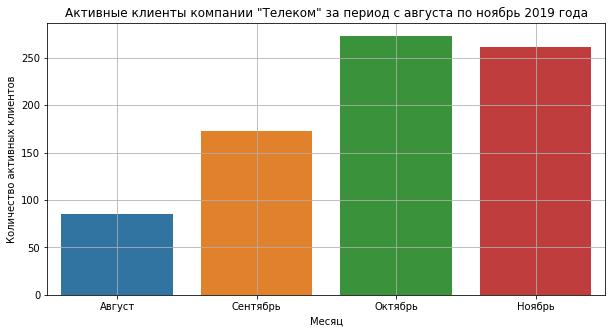

In [68]:
# График
plt.figure(figsize=(10, 5))
sns.barplot(data=clients, x="mounth", y="total_client")
plt.title('Активные клиенты компании "Телеком" за период с августа по ноябрь 2019 года')
plt.xlabel('Месяц')
plt.ylabel('Количество активных клиентов')
plt.grid()
plt.show()

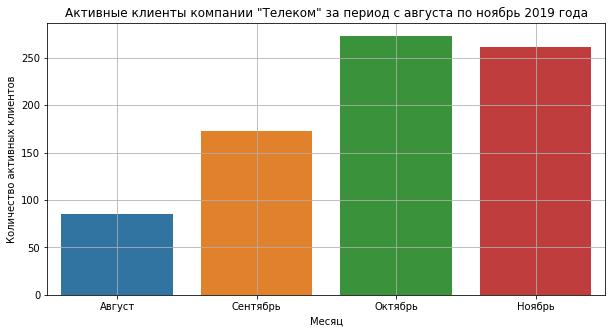

In [69]:
# ячейка тимлида:
plt.figure(figsize=(10, 5))
sns.barplot(data=df.groupby('mounth').agg(total_client = ('user_id','nunique')).reset_index(), 
            x="mounth", y="total_client").set_xticklabels(['Август', 'Сентябрь', 'Октябрь', 'Ноябрь'])
plt.title('Активные клиенты компании "Телеком" за период с августа по ноябрь 2019 года')
plt.xlabel('Месяц')
plt.ylabel('Количество активных клиентов')
plt.grid()
plt.show()

#### Проверим работу операторов:

In [70]:
# Осуществим группировку по идентификатору клиента и укажем сумму в колонках
df_groupby_operator = df.groupby('operator_id')['calls_count', 'call_duration', 'total_call_duration'].agg('sum').reset_index()
df_groupby_operator.sort_values(by='total_call_duration', ascending=False)

,operator_id,calls_count,call_duration,total_call_duration
28,"885,876.00",59429,4363953,5733237
29,"885,890.00",60221,3340790,4783792
551,"925,922.00",20021,828782,1252549
583,"929,428.00",23754,277118,633196
958,"952,948.00",4718,471369,492937
...,...,...,...,...
982,"955,068.00",2,0,0
874,"946,454.00",13,0,0
386,"914,626.00",1,0,0
1011,"958,458.00",1,0,0


Видим, что у трех операторов большое количество длительности звонка без учета/с учетом времени ожидания. Возможно действительно был сбой. Рассмотрим этих операторов более детально:

In [71]:
# Посмотрим для начала, сколько всего операторов
df['operator_id'].nunique()

1092

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
 9   mounth               48892 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 3.4+ MB


In [73]:
# Сделаем срез по оператору с самым большим временем разговора
df_operator_885876 = df.query('operator_id == 885876')
df_operator_885876.sort_values(by='total_call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
6312,166582,2019-09-25,out,False,"885,876.00",False,1230,144395,166155,9
6316,166582,2019-09-26,out,False,"885,876.00",False,843,132206,146903,9
6186,166582,2019-09-09,out,False,"885,876.00",False,1138,121093,141930,9
6260,166582,2019-09-18,out,False,"885,876.00",False,1013,121664,140050,9
6210,166582,2019-09-12,out,False,"885,876.00",False,696,125286,138643,9
6361,166582,2019-10-02,out,False,"885,876.00",False,995,120175,137324,10
6202,166582,2019-09-11,out,False,"885,876.00",False,946,115057,132708,9
6292,166582,2019-09-23,out,False,"885,876.00",False,1436,103526,129484,9
6428,166582,2019-10-09,out,False,"885,876.00",False,696,117177,129395,10
6272,166582,2019-09-20,out,False,"885,876.00",False,737,114463,127868,9


Видим, что действительно очень большие цифры времени разговора. Так как рабочая смена оператора 12 часов максимум, то переведем колонку длительность звонка без учета времени ожидания в часы:

In [74]:
# 1 час = 60 минут = 3600 секунд
df_operator_885876['call_duration'] = df_operator_885876['call_duration'] // 3600

In [75]:
df_operator_885876.sort_values(by='call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
6312,166582,2019-09-25,out,False,"885,876.00",False,1230,40,166155,9
6316,166582,2019-09-26,out,False,"885,876.00",False,843,36,146903,9
6210,166582,2019-09-12,out,False,"885,876.00",False,696,34,138643,9
6361,166582,2019-10-02,out,False,"885,876.00",False,995,33,137324,10
6260,166582,2019-09-18,out,False,"885,876.00",False,1013,33,140050,9
6186,166582,2019-09-09,out,False,"885,876.00",False,1138,33,141930,9
6428,166582,2019-10-09,out,False,"885,876.00",False,696,32,129395,10
6322,166582,2019-09-27,out,False,"885,876.00",False,754,31,127751,9
6202,166582,2019-09-11,out,False,"885,876.00",False,946,31,132708,9
6272,166582,2019-09-20,out,False,"885,876.00",False,737,31,127868,9


In [76]:
df_operator_885876['user_id'].nunique()

1

Видим, что сбой был в сентябре. Посмотрим, много ли дат, когда был сбой:

In [77]:
# Сделаем срез с 1 по 30 сентября и укажем время больше 12 часов
df_operator_885876[(df_operator_885876['date'] > '2019-09-01') & (
    df_operator_885876['date'] < '2019-09-30') & (
    df_operator_885876['call_duration']>12)].sort_values(by='date')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
6129,166582,2019-09-02,out,False,"885,876.00",False,1018,25,108665,9
6137,166582,2019-09-03,out,False,"885,876.00",False,1137,24,109600,9
6144,166582,2019-09-04,out,False,"885,876.00",False,863,25,107524,9
6151,166582,2019-09-05,out,False,"885,876.00",False,602,30,120064,9
6168,166582,2019-09-06,out,False,"885,876.00",False,584,24,98711,9
6186,166582,2019-09-09,out,False,"885,876.00",False,1138,33,141930,9
6194,166582,2019-09-10,out,False,"885,876.00",False,1053,22,100139,9
6202,166582,2019-09-11,out,False,"885,876.00",False,946,31,132708,9
6210,166582,2019-09-12,out,False,"885,876.00",False,696,34,138643,9
6221,166582,2019-09-13,out,False,"885,876.00",False,652,27,111703,9


Получается, что информация о сбое подтверждается: в сентябре оператор "885,876.00" в некоторые даты записывал все звонки на себя

А теперь возьмем четвертого (по количеству активного разговора) оператора и проверим его на аномальные звонки:

In [78]:
# Сделаем срез по оператору с четвертым временем разговора
df_operator_929428 = df.query('operator_id == 929428')
df_operator_929428.sort_values(by='call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
36875,167827,2019-10-25,out,False,"929,428.00",False,273,22270,27204,10
36888,167827,2019-10-28,out,False,"929,428.00",False,240,17037,21536,10
36920,167827,2019-11-01,out,False,"929,428.00",False,273,14584,19081,11
36814,167827,2019-10-16,out,False,"929,428.00",False,191,13193,17099,10
36818,167827,2019-10-17,out,False,"929,428.00",False,206,13125,17227,10
36946,167827,2019-11-08,out,False,"929,428.00",False,241,13101,17201,11
36984,167827,2019-11-16,out,False,"929,428.00",False,163,11756,14786,11
36944,167827,2019-11-07,out,False,"929,428.00",False,223,11488,14830,11
36857,167827,2019-10-23,out,False,"929,428.00",False,216,10701,14431,10
36882,167827,2019-10-26,out,False,"929,428.00",False,130,10632,13078,10


In [79]:
df_operator_929428['call_duration'] = df_operator_929428['call_duration'] // 3600

In [80]:
df_operator_929428.sort_values(by='call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
36875,167827,2019-10-25,out,False,"929,428.00",False,273,6,27204,10
36920,167827,2019-11-01,out,False,"929,428.00",False,273,4,19081,11
36888,167827,2019-10-28,out,False,"929,428.00",False,240,4,21536,10
36818,167827,2019-10-17,out,False,"929,428.00",False,206,3,17227,10
36984,167827,2019-11-16,out,False,"929,428.00",False,163,3,14786,11
36944,167827,2019-11-07,out,False,"929,428.00",False,223,3,14830,11
36946,167827,2019-11-08,out,False,"929,428.00",False,241,3,17201,11
36814,167827,2019-10-16,out,False,"929,428.00",False,191,3,17099,10
36828,167827,2019-10-18,out,False,"929,428.00",False,95,2,9323,10
36865,167827,2019-10-24,out,False,"929,428.00",False,157,2,13372,10


Видим, что результаты четвертого оператора в норме и количество часов не превышало рабочее время.

Проверим тогда и третьего оператора, так как у второго тоже высокие значения:

In [81]:
# Сделаем срез по оператору с третьим временем разговора
df_operator_925922 = df.query('operator_id == 925922')
df_operator_925922.sort_values(by='call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
6377,166582,2019-10-04,out,False,"925,922.00",False,544,60890,70403,10
6375,166582,2019-10-03,out,False,"925,922.00",False,564,59922,70031,10
6497,166582,2019-10-16,out,False,"925,922.00",False,594,57955,67752,10
6440,166582,2019-10-10,out,False,"925,922.00",False,581,56676,66860,10
6434,166582,2019-10-09,out,False,"925,922.00",False,532,54897,63964,10
6507,166582,2019-10-17,out,False,"925,922.00",False,691,52141,64416,10
6424,166582,2019-10-08,out,False,"925,922.00",False,790,49497,63765,10
6458,166582,2019-10-11,out,False,"925,922.00",False,597,47815,58656,10
6409,166582,2019-10-07,out,False,"925,922.00",False,682,45132,56801,10
6485,166582,2019-10-15,out,False,"925,922.00",False,813,44611,59364,10


In [82]:
df_operator_925922['call_duration'] = df_operator_925922['call_duration'] // 3600

In [83]:
df_operator_925922.sort_values(by='call_duration', ascending=False).head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth
6497,166582,2019-10-16,out,False,"925,922.00",False,594,16,67752,10
6375,166582,2019-10-03,out,False,"925,922.00",False,564,16,70031,10
6377,166582,2019-10-04,out,False,"925,922.00",False,544,16,70403,10
6440,166582,2019-10-10,out,False,"925,922.00",False,581,15,66860,10
6434,166582,2019-10-09,out,False,"925,922.00",False,532,15,63964,10
6507,166582,2019-10-17,out,False,"925,922.00",False,691,14,64416,10
6458,166582,2019-10-11,out,False,"925,922.00",False,597,13,58656,10
6424,166582,2019-10-08,out,False,"925,922.00",False,790,13,63765,10
6475,166582,2019-10-14,out,False,"925,922.00",False,684,12,55481,10
6485,166582,2019-10-15,out,False,"925,922.00",False,813,12,59364,10


In [84]:
# Количество клиентов
df_operator_925922['user_id'].nunique()

1

Видим, что у третьего оператора тоже перекос по количеству часов, хоть уже и не так, как у первого.

##### Промежуточный вывод по операторам:
* Информация о сбое подтвердилась: в сентябре и октябре звонки записывались на одного оператора. Причем от одного клиента.
* И таких операторов получилось 3: `885,876.00`, `885,890.00`, `925,922.00`.

#### Определение количества клиентов на каждом тарифе:

Теперь поработаем со вторым датасетом:

In [85]:
df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


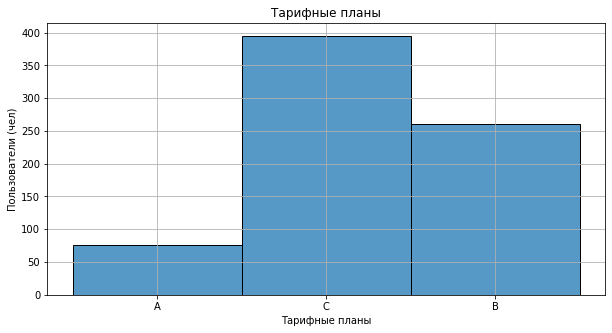

In [86]:
# Посмотрим наглядно
plt.figure(figsize=(10, 5))
sns.histplot(df_clients['tariff_plan']).set_title("Тарифные планы")
plt.xlabel('Тарифные планы')
plt.ylabel('Пользователи (чел)')
plt.grid()
plt.show()

In [87]:
# Посчитаем количество клиентов на каждом тарифе
df_clients_groupby = df_clients.groupby('tariff_plan')['user_id'].agg('count')
df_clients_groupby.sort_values(ascending=False)

tariff_plan
C    395
B    261
A     76
Name: user_id, dtype: int64

Логично, что больше всего пользователей на самом дешевом тарифе "С".

#### Определим средние траты клиентов на тарифах:

Осуществим объединение датасетов:

In [88]:
# Воспользуемся методом `merge()`
df_new = df.merge(df_clients, how = 'inner')
df_new.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mounth,tariff_plan,date_start
0,166377,2019-08-04,in,False,NaN,True,2,0,4,8,B,2019-08-01
1,166377,2019-08-05,out,True,"880,022.00",True,3,0,5,8,B,2019-08-01
2,166377,2019-08-05,out,True,"880,020.00",True,1,0,1,8,B,2019-08-01
3,166377,2019-08-05,out,True,"880,020.00",False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,"880,022.00",True,3,0,25,8,B,2019-08-01


Cоздадим функцию, в которой согласно условиям определим траты каждого клиента за указанный период. В функции секунды переведем в минуты, так как указана плата за минуту:

In [89]:
# Удалим столбец с месяцем, т.к. в функции выделяем его
df_new.drop(columns='mounth', inplace=True)

In [90]:
def func(df):
    # Создадим словарь с данными из задачи
    tariff_price = {
        'A': 5000,
        'B': 2000,
        'C': 1000
    } # Ежемесячная плата за тариф
 
    out_call_price_in_network = {
        'A': 0.1,
        'B': 0.15,
        'C': 0.3
    } # Исходящие звонки внутри сети
 
    out_call_price_out_network = {
        'A': 0.4,
        'B': 0.5,
        'C': 0.7
    } # Исходящие звонки, кроме внутренних
 
 
    tmp_df = df_new.copy()
 
    tmp_df['month_date'] = tmp_df['date'].dt.month # Выделим столбец месяца
     
    # Исходящие звонки внутри сети
    # Группируем по клиенту и месяцу
    # сумма звонка с учетом времени ожидания
    # для удобства переименуем колонку
    # делаем срез: больше 2000 минут * 60 секунд (т.к. данные в секундах)
    
    calls_out_inter = tmp_df.query('direction == "out" and internal == True') \
         .groupby(['user_id', 'month_date'], as_index=False) \
         .agg({'total_call_duration': 'sum'}) \
         .rename({'total_call_duration': 'sum_in_network'}, axis=1) \
         .query('sum_in_network >= 2000 * 60')
 
    # Исходящие звонки в другие сети
    # Группируем по клиенту и месяцу
    # сумма звонка с учетом времени ожидания
    # для удобства переименуем колонку
    
    calls_in_not_inter = tmp_df.query('direction == "out" and internal == False') \
          .groupby(['user_id', 'month_date'], as_index=False) \
          .agg({'total_call_duration': 'sum'}) \
          .rename({'total_call_duration': 'sum_out_network'}, axis=1)
    
    # Посчитаем на каждого клиента количество уникальных операторов
    user_n_paids = tmp_df.groupby(['user_id', 'tariff_plan', 'month_date'], as_index=False) \
                        .agg({'operator_id': 'nunique'})
 
    # Объединим месяцы, звонки внутри сети и в другие сети
    total_df = user_n_paids.merge(calls_out_inter, on=['user_id', 'month_date'], how='left') \
                           .merge(calls_in_not_inter, on=['user_id', 'month_date'], how='left')
 
    # Осуществим замену
    total_df['tariff_price'] = total_df['tariff_plan'].replace(tariff_price)
    total_df['price_in_network'] = total_df['tariff_plan'].replace(out_call_price_in_network)
    total_df['price_out_network'] = total_df['tariff_plan'].replace(out_call_price_out_network)
 
    # Пропущенные значения заменим на 0
    total_df.fillna(0, inplace=True)
 
    # Переведем значения столбца в минуты с округлением в большую сторону и поменяем тип
    total_df['sum_in_network'] = np.ceil(total_df['sum_in_network'] / 60).astype('int64')
    total_df['sum_out_network'] = np.ceil(total_df['sum_out_network'] / 60).astype('int64')
 
    # В новом столбце сложим все полученные значения и прибавим 100 рублей умноженные на количество уникальных операторов
    total_df['total_money'] = ((total_df['tariff_price'] + 100 * total_df['operator_id'])
                                + total_df['sum_in_network'] * total_df['price_in_network']
                               + total_df['sum_out_network'] * total_df['price_out_network'])
    return total_df

In [91]:
income = func(df_new)
income.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money
0,166377,B,8,5,0,1301,2000,0.15,0.50,"3,150.50"
1,166377,B,9,4,0,1764,2000,0.15,0.50,"3,282.00"
2,166377,B,10,5,0,1654,2000,0.15,0.50,"3,327.00"
3,166377,B,11,4,0,1590,2000,0.15,0.50,"3,195.00"
4,166391,C,8,2,0,0,1000,0.30,0.70,"1,200.00"


Посмотрим на графике сумму дохода компании (траты клиентов по месяцам):

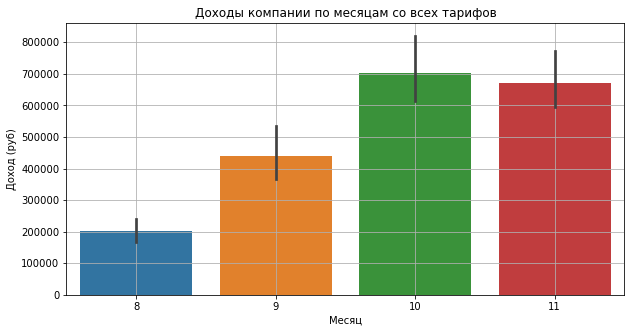

In [92]:
# Построим график
plt.figure(figsize=(10, 5))
sns.barplot(data=income, x='month_date', y='total_money', estimator = np.sum)
plt.title('Доходы компании по месяцам со всех тарифов')
plt.xlabel('Месяц')
plt.ylabel('Доход (руб)')
plt.grid()
plt.show()

Построим общую таблицу по месяцам и тарифному плану: выясним, сколько количество пользователей на тарифе и какую сумму они потратили:

In [93]:
table = income.groupby(
    ['month_date', 'tariff_plan'])['user_id', 'total_money'].agg(
    {'user_id':'count', 'total_money':['sum', 'mean']}).reset_index()

In [94]:
# Уберем мультииндекс после группировки
table.columns = table.columns.map(''.join)

In [95]:
# Переименуем колонки
table.rename(columns={
    'user_idcount':'user_id_count',
    'total_moneysum':'total_money_sum',
    'total_moneymean':'total_money_mean'
}, inplace=True)

Будем считать, что актуальная информация - это информация за последние три месяца. В нашем случае - это сентябрь, октябрь и ноябрь. Удалим месяц август из нашего датафрейма:

In [96]:
table.query('month_date != 8', inplace=True)

In [97]:
table

,month_date,tariff_plan,user_id_count,total_money_sum,total_money_mean
3,9,A,19,"147,047.20","7,739.33"
4,9,B,66,"162,067.00","2,455.56"
5,9,C,88,"131,700.80","1,496.60"
6,10,A,33,"254,484.00","7,711.64"
7,10,B,92,"232,815.00","2,530.60"
8,10,C,148,"216,577.10","1,463.36"
9,11,A,30,"221,350.00","7,378.33"
10,11,B,96,"248,112.00","2,584.50"
11,11,C,135,"202,244.10","1,498.10"


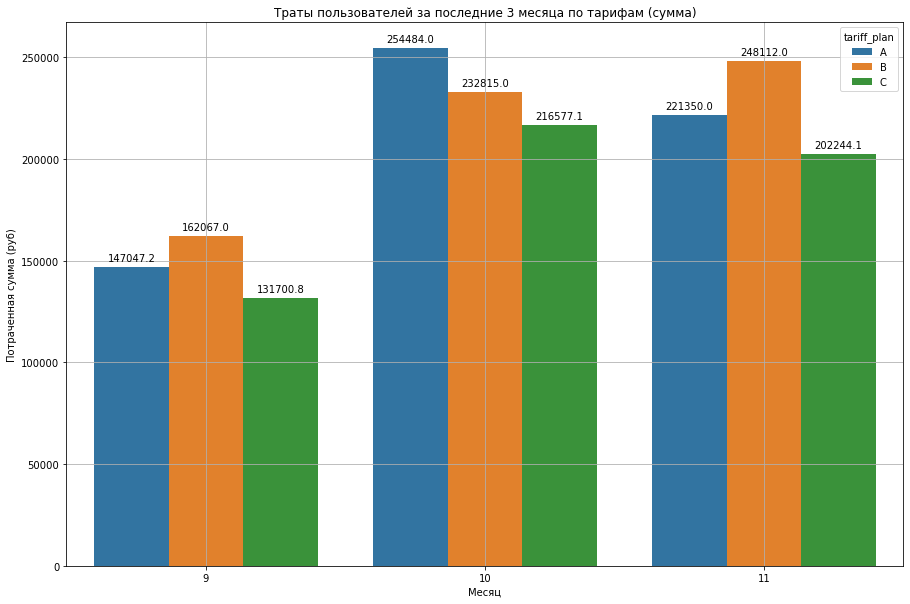

In [98]:
# Построим график
plt.figure(figsize=(15, 10))
splot=sns.barplot(x="month_date", y="total_money_sum", hue="tariff_plan", data=table)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Траты пользователей за последние 3 месяца по тарифам (сумма)')
plt.xlabel('Месяц')
plt.ylabel('Потраченная сумма (руб)')
plt.grid()
plt.show()

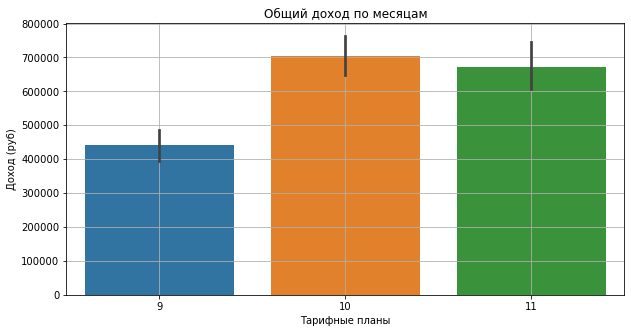

In [99]:
# Построим график дохода за 3 месяца
plt.figure(figsize=(10, 5))
sns.barplot(data=table, x='month_date', y='total_money_sum', estimator = np.sum)
plt.title('Общий доход по месяцам')
plt.xlabel('Тарифные планы')
plt.ylabel('Доход (руб)')
plt.grid()
plt.show()

Больше всего клиенты тратили в октябре, что логично, так как выше мы узнали, что в ноябре пошел спад клиентов.

Средние доход компании с тарифов:

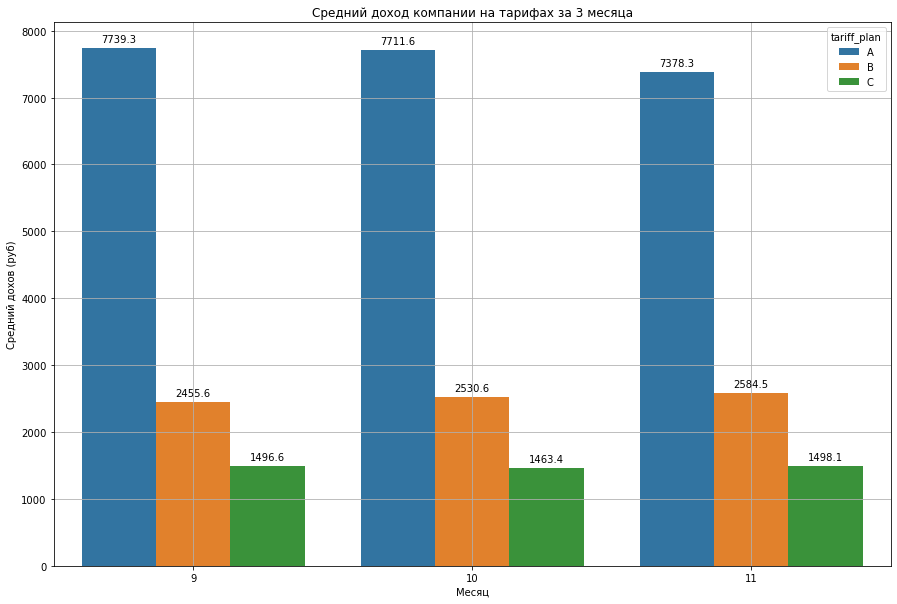

In [100]:
# Построим график
plt.figure(figsize=(15, 10))
splot=sns.barplot(x="month_date", y="total_money_mean", hue="tariff_plan", data=table)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Средний доход компании на тарифах за 3 месяца')
plt.xlabel('Месяц')
plt.ylabel('Средний дохов (руб)')
plt.grid()
plt.show()

Посчитаем количество пользователей на тарифах:

In [101]:
# Девятый месяц - сентябрь
table.query('month_date == 9')['user_id_count'].sum()

173

In [102]:
month_9 = pd.DataFrame({
    'tariff_name':['A', 'B', 'C'],
    'user_count':[19, 66, 88],
    })

In [103]:
month_9['percent'] = month_9['user_count']/table.query('month_date == 9')['user_id_count'].sum() * 100
month_9['percent'] = round(month_9['percent'])
month_9['percent'] = month_9['percent'].astype('int')
month_9['percent'] = month_9['percent'].astype('str').add('%')
month_9

,tariff_name,user_count,percent
0,A,19,11%
1,B,66,38%
2,C,88,51%


В сентябре больше половины пользователей были на тарифе "С"

In [104]:
# Десятый месяц - октябрь
table.query('month_date == 10')['user_id_count'].sum()

273

In [105]:
month_10 = pd.DataFrame({
    'tariff_name':['A', 'B', 'C'],
    'user_count':[33, 92, 148],
    })

In [106]:
month_10['percent'] = month_10['user_count']/table.query('month_date == 10')['user_id_count'].sum() * 100
month_10['percent'] = round(month_10['percent'])
month_10['percent'] = month_10['percent'].astype('int')
month_10['percent'] = month_10['percent'].astype('str').add('%')
month_10

,tariff_name,user_count,percent
0,A,33,12%
1,B,92,34%
2,C,148,54%


В октябре пользователей увеличилось на тарифах "С" и "А"

In [107]:
# Одиннадцатый месяц - ноябрь
table.query('month_date == 11')['user_id_count'].sum()

261

In [108]:
month_11 = pd.DataFrame({
    'tariff_name':['A', 'B', 'C'],
    'user_count':[30, 96, 135],
    })

In [109]:
month_11['percent'] = month_11['user_count']/table.query('month_date == 11')['user_id_count'].sum() * 100
month_11['percent'] = round(month_11['percent'])
month_11['percent'] = month_11['percent'].astype('int')
month_11['percent'] = month_11['percent'].astype('str').add('%')
month_11

,tariff_name,user_count,percent
0,A,30,11%
1,B,96,37%
2,C,135,52%


В принципе, можно сделать вывод, что за 3 месяца пользователи распределены следующим образом:
* На тарифе "А" - 11-12% от общего количества;
* На тарифе "В" - 34-38% от общего количества;
* На тарифе "С" - 51-54% от общего количества.

Т.е. больше половины пользователей находятся на тарифе "С"

#### Определим доходы с каждого тарифа:

Возьмем актуальные данные за 3 месяца:

In [110]:
total_income = table.groupby('tariff_plan')['total_money_sum'].agg('sum').reset_index()
total_income

,tariff_plan,total_money_sum
0,A,"622,881.20"
1,B,"642,994.00"
2,C,"550,522.00"


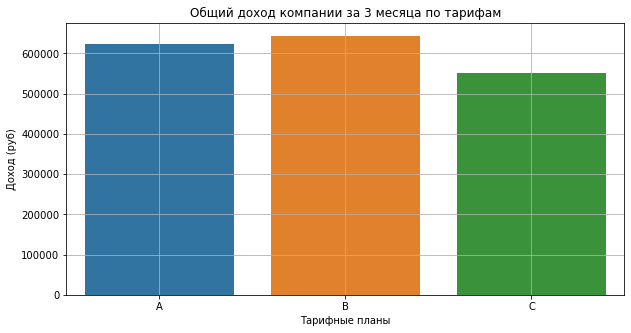

In [111]:
# Построим график дохода за 3 месяца
plt.figure(figsize=(10, 5))
sns.barplot(data=total_income, x='tariff_plan', y='total_money_sum')
plt.title('Общий доход компании за 3 месяца по тарифам')
plt.xlabel('Тарифные планы')
plt.ylabel('Доход (руб)')
plt.grid()
plt.show()

#### Сделаем анализ неоптимального использования тарифов клиентами и подберем оптимальный тариф для активных клиентов:

In [112]:
income.head(2)

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money
0,166377,B,8,5,0,1301,2000,0.15,0.50,"3,150.50"
1,166377,B,9,4,0,1764,2000,0.15,0.50,"3,282.00"


In [113]:
tariff_A = income.loc[income['tariff_plan'] == "A"].reset_index()
tariff_A.drop(
    columns=['index', 'operator_id', 'user_id', 'month_date', 'sum_in_network', 'sum_out_network', 'total_money'], inplace=True)

In [114]:
tariff_A = tariff_A.loc[[0]]
tariff_A

,tariff_plan,tariff_price,price_in_network,price_out_network
0,A,5000,0.10,0.40


In [115]:
tariff_B = income.loc[income['tariff_plan'] == "B"].reset_index()
tariff_B.drop(
    columns=['index', 'operator_id', 'user_id', 'month_date', 'sum_in_network', 'sum_out_network', 'total_money'], inplace=True)

In [116]:
tariff_B = tariff_B.loc[[0]]
tariff_B

,tariff_plan,tariff_price,price_in_network,price_out_network
0,B,2000,0.15,0.50


In [117]:
tariff_C = income.loc[income['tariff_plan'] == "C"].reset_index()
tariff_C.drop(
    columns=['index', 'operator_id', 'user_id', 'month_date', 'sum_in_network', 'sum_out_network', 'total_money'], inplace=True)

In [118]:
tariff_C = tariff_C.loc[[0]]
tariff_C

,tariff_plan,tariff_price,price_in_network,price_out_network
0,C,1000,0.30,0.70


Выделим пользователей на тарифных планах:

In [119]:
# Тарифный план "А"
user_A = income.query('tariff_plan == "A" & month_date != 8')
user_A.drop(columns=['tariff_price', 'price_in_network', 'price_out_network'], inplace=True)
user_A.rename(columns={'total_money': 'tariff_A'}, inplace=True)
user_A.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_A
24,166407,A,9,7,0,40,"5,716.00"
25,166407,A,10,7,0,218,"5,787.20"
26,166407,A,11,8,0,124,"5,849.60"
32,166481,A,9,0,0,0,"5,000.00"
33,166481,A,10,0,0,0,"5,000.00"


In [120]:
user_A['tariff_AB'] = (user_A['sum_in_network']*tariff_B.loc[0]['price_in_network']) + \
                (user_A['sum_out_network']*tariff_B.loc[0]['price_out_network']) + \
                (user_A['operator_id']*100) + \
                tariff_B.loc[0]['tariff_price'].astype('int64')

In [121]:
user_A['tariff_AC'] = (user_A['sum_in_network']*tariff_C.loc[0]['price_in_network']) + \
                (user_A['sum_out_network']*tariff_C.loc[0]['price_out_network']) + \
                (user_A['operator_id']*100) + \
                tariff_C.loc[0]['tariff_price'].astype('int64')

In [122]:
user_A.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_A,tariff_AB,tariff_AC
24,166407,A,9,7,0,40,"5,716.00","2,720.00","1,728.00"
25,166407,A,10,7,0,218,"5,787.20","2,809.00","1,852.60"
26,166407,A,11,8,0,124,"5,849.60","2,862.00","1,886.80"
32,166481,A,9,0,0,0,"5,000.00","2,000.00","1,000.00"
33,166481,A,10,0,0,0,"5,000.00","2,000.00","1,000.00"


In [123]:
# Тарифный план "В"
user_B = income.query('tariff_plan == "B" & month_date != 8')
user_B.drop(columns=['tariff_price', 'price_in_network', 'price_out_network'], inplace=True)
user_B.rename(columns={'total_money': 'tariff_B'}, inplace=True)
user_B.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_B
1,166377,B,9,4,0,1764,"3,282.00"
2,166377,B,10,5,0,1654,"3,327.00"
3,166377,B,11,4,0,1590,"3,195.00"
16,166405,B,9,4,0,2013,"3,406.50"
17,166405,B,10,10,0,6298,"6,149.00"


In [124]:
user_B['tariff_BA'] = (user_B['sum_in_network']*tariff_A.loc[0]['price_in_network']) + \
                (user_B['sum_out_network']*tariff_A.loc[0]['price_out_network']) + \
                (user_B['operator_id']*100) + \
                tariff_A.loc[0]['tariff_price'].astype('int64')

In [125]:
user_B['tariff_BC'] = (user_B['sum_in_network']*tariff_C.loc[0]['price_in_network']) + \
                (user_B['sum_out_network']*tariff_C.loc[0]['price_out_network']) + \
                (user_B['operator_id']*100) + \
                tariff_C.loc[0]['tariff_price'].astype('int64')

In [126]:
user_B.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_B,tariff_BA,tariff_BC
1,166377,B,9,4,0,1764,"3,282.00","6,105.60","2,634.80"
2,166377,B,10,5,0,1654,"3,327.00","6,161.60","2,657.80"
3,166377,B,11,4,0,1590,"3,195.00","6,036.00","2,513.00"
16,166405,B,9,4,0,2013,"3,406.50","6,205.20","2,809.10"
17,166405,B,10,10,0,6298,"6,149.00","8,519.20","6,408.60"


In [127]:
# Тарифный план "C"
user_C = income.query('tariff_plan == "C" & month_date != 8')
user_C.drop(columns=['tariff_price', 'price_in_network', 'price_out_network'], inplace=True)
user_C.rename(columns={'total_money': 'tariff_C'}, inplace=True)
user_C.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_C
5,166391,C,9,1,0,0,"1,100.00"
6,166391,C,10,0,0,0,"1,000.00"
7,166391,C,11,1,0,0,"1,100.00"
9,166392,C,9,2,0,0,"1,200.00"
10,166392,C,10,2,0,0,"1,200.00"


In [128]:
user_C['tariff_CA'] = (user_C['sum_in_network']*tariff_A.loc[0]['price_in_network']) + \
                (user_C['sum_out_network']*tariff_A.loc[0]['price_out_network']) + \
                (user_C['operator_id']*100) + \
                tariff_A.loc[0]['tariff_price'].astype('int64')

In [129]:
user_C['tariff_CB'] = (user_C['sum_in_network']*tariff_B.loc[0]['price_in_network']) + \
                (user_C['sum_out_network']*tariff_B.loc[0]['price_out_network']) + \
                (user_C['operator_id']*100) + \
                tariff_B.loc[0]['tariff_price'].astype('int64')

In [130]:
user_C.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_C,tariff_CA,tariff_CB
5,166391,C,9,1,0,0,"1,100.00","5,100.00","2,100.00"
6,166391,C,10,0,0,0,"1,000.00","5,000.00","2,000.00"
7,166391,C,11,1,0,0,"1,100.00","5,100.00","2,100.00"
9,166392,C,9,2,0,0,"1,200.00","5,200.00","2,200.00"
10,166392,C,10,2,0,0,"1,200.00","5,200.00","2,200.00"


In [131]:
user_A.rename(columns={'tariff_A': 'revenue_A', 'tariff_AB': 'revenue_A', 'tariff_AC': 'revenue_C'}, inplace=True)

In [132]:
user_B.rename(columns={'tariff_BA': 'revenue_A', 'tariff_B': 'revenue_B', 'tariff_BC': 'revenue_C'}, inplace=True)

In [133]:
user_C.rename(columns={'tariff_CA': 'revenue_A', 'tariff_CB': 'revenue_B', 'tariff_C': 'revenue_C'}, inplace=True)

In [134]:
user_B = user_B.reindex(
    columns=['user_id','tariff_plan','month_date','operator_id','sum_in_network','sum_out_network', \
            'revenue_A', 'revenue_B', 'revenue_C'])
user_B.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,revenue_A,revenue_B,revenue_C
1,166377,B,9,4,0,1764,"6,105.60","3,282.00","2,634.80"
2,166377,B,10,5,0,1654,"6,161.60","3,327.00","2,657.80"
3,166377,B,11,4,0,1590,"6,036.00","3,195.00","2,513.00"
16,166405,B,9,4,0,2013,"6,205.20","3,406.50","2,809.10"
17,166405,B,10,10,0,6298,"8,519.20","6,149.00","6,408.60"


In [135]:
user_C = user_C.reindex(
    columns=['user_id','tariff_plan','month_date','operator_id','sum_in_network','sum_out_network', \
            'revenue_A', 'revenue_B', 'revenue_C'])
user_C.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,revenue_A,revenue_B,revenue_C
5,166391,C,9,1,0,0,"5,100.00","2,100.00","1,100.00"
6,166391,C,10,0,0,0,"5,000.00","2,000.00","1,000.00"
7,166391,C,11,1,0,0,"5,100.00","2,100.00","1,100.00"
9,166392,C,9,2,0,0,"5,200.00","2,200.00","1,200.00"
10,166392,C,10,2,0,0,"5,200.00","2,200.00","1,200.00"


In [136]:
user_A.reset_index(inplace=True, drop=True)
user_B.reset_index(inplace=True, drop=True)

In [137]:
user_A.head(2)

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,revenue_A,revenue_A,revenue_C
0,166407,A,9,7,0,40,"5,716.00","2,720.00","1,728.00"
1,166407,A,10,7,0,218,"5,787.20","2,809.00","1,852.60"


In [138]:
user_B.head(2)

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,revenue_A,revenue_B,revenue_C
0,166377,B,9,4,0,1764,"6,105.60","3,282.00","2,634.80"
1,166377,B,10,5,0,1654,"6,161.60","3,327.00","2,657.80"


In [139]:


tmp = income.copy()

tmp['revenue_A'] = (tmp['sum_in_network']*tariff_A.loc[0]['price_in_network']) + \
                (tmp['sum_out_network']*tariff_A.loc[0]['price_out_network']) + \
                (tmp['operator_id']*100) + \
                tariff_A.loc[0]['tariff_price'].astype('int64')
tmp['revenue_B'] = (tmp['sum_in_network']*tariff_B.loc[0]['price_in_network']) + \
                (tmp['sum_out_network']*tariff_B.loc[0]['price_out_network']) + \
                (tmp['operator_id']*100) + \
                tariff_B.loc[0]['tariff_price'].astype('int64')
tmp['revenue_C'] = (tmp['sum_in_network']*tariff_C.loc[0]['price_in_network']) + \
                (tmp['sum_out_network']*tariff_C.loc[0]['price_out_network']) + \
                (tmp['operator_id']*100) + \
                tariff_C.loc[0]['tariff_price'].astype('int64')
tmp.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money,revenue_A,revenue_B,revenue_C
0,166377,B,8,5,0,1301,2000,0.15,0.50,"3,150.50","6,020.40","3,150.50","2,410.70"
1,166377,B,9,4,0,1764,2000,0.15,0.50,"3,282.00","6,105.60","3,282.00","2,634.80"
2,166377,B,10,5,0,1654,2000,0.15,0.50,"3,327.00","6,161.60","3,327.00","2,657.80"
3,166377,B,11,4,0,1590,2000,0.15,0.50,"3,195.00","6,036.00","3,195.00","2,513.00"
4,166391,C,8,2,0,0,1000,0.30,0.70,"1,200.00","5,200.00","2,200.00","1,200.00"


In [140]:

exmp = tmp.copy()
# найдем текущий тариф:
exmp['current_tariff_revenue'] = exmp.apply(lambda x:  x['revenue_A'] if x['tariff_plan'] == "A" \
                                            else (x['revenue_B'] if x['tariff_plan']  == "B" else x['revenue_C']), axis = 1)

# найдем оптимальный тариф:
exmp['revenue_opt'] = exmp.apply(lambda x:  min(x['revenue_A'],x['revenue_B'],x['revenue_C']), axis = 1)
exmp['tariff_opt'] = exmp.apply(lambda x: "A" if x['revenue_opt'] == x['revenue_A'] \
                              else ("B" if x['revenue_opt'] == x['revenue_B'] else "C"), axis = 1)

# подсчитаем дельту:
exmp['delta'] = exmp['current_tariff_revenue'] - exmp['revenue_opt']
exmp.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money,revenue_A,revenue_B,revenue_C,current_tariff_revenue,revenue_opt,tariff_opt,delta
0,166377,B,8,5,0,1301,2000,0.15,0.50,"3,150.50","6,020.40","3,150.50","2,410.70","3,150.50","2,410.70",C,739.80
1,166377,B,9,4,0,1764,2000,0.15,0.50,"3,282.00","6,105.60","3,282.00","2,634.80","3,282.00","2,634.80",C,647.20
2,166377,B,10,5,0,1654,2000,0.15,0.50,"3,327.00","6,161.60","3,327.00","2,657.80","3,327.00","2,657.80",C,669.20
3,166377,B,11,4,0,1590,2000,0.15,0.50,"3,195.00","6,036.00","3,195.00","2,513.00","3,195.00","2,513.00",C,682.00
4,166391,C,8,2,0,0,1000,0.30,0.70,"1,200.00","5,200.00","2,200.00","1,200.00","1,200.00","1,200.00",C,0.00


#### Рассмотрим доход, если клиентов перевести на выгодный для них тариф:

#### Тариф "А":

In [141]:
# Посчитаем количество клиентов по месяцам на тарифе и доход, если бы клиент был на оптимальном тарифе
user_A_opt = exmp.query('tariff_plan == "A" & month_date != 8')
user_A_opt = user_A_opt.groupby(
    ['month_date', 'tariff_opt'])['user_id', 'revenue_opt'].agg({'user_id':'count', 'revenue_opt':'sum'}).reset_index()
user_A_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,A,1,"38,830.00"
1,9,B,1,"16,987.50"
2,9,C,17,"22,532.60"
3,10,A,2,"66,148.00"
4,10,B,2,"20,500.50"
5,10,C,29,"51,847.30"
6,11,A,1,"36,337.60"
7,11,B,3,"35,502.00"
8,11,C,26,"44,088.90"


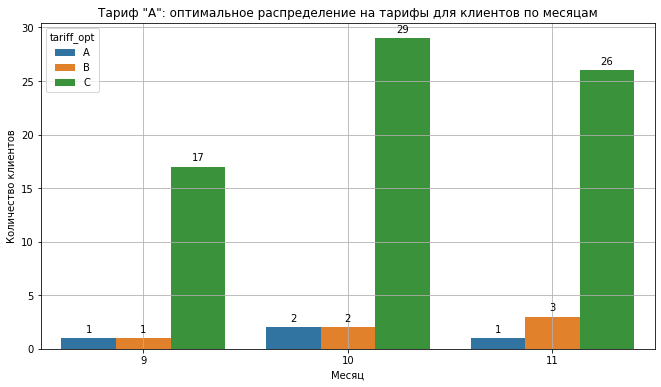

In [142]:
# Построим график
plt.figure(figsize=(11, 6))
splot=sns.barplot(x="month_date", y="user_id", hue="tariff_opt", data=user_A_opt)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Тариф "А": оптимальное распределение на тарифы для клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.grid()
plt.show()

По графику видим, что в основном клиентам тарифа "А" выгоднее переходить на тариф "С". Посчитаем, сколько мы потеряем, если всех клиентов переведем на тариф "С":

In [143]:
# Посчитаем доход в настоящее время за 3 месяца
exmp.query('tariff_plan == "A" & month_date != 8')['revenue_A'].sum()

622881.2

In [144]:
# Посчитаем доход, если бы всех клиентов тарифа "А" перевели на оптимальные для них тарифы
user_A_opt.query('tariff_opt != "A"')['revenue_opt'].sum()

191458.8

In [145]:
(exmp.query('tariff_plan == "A" & month_date != 8')['revenue_A'].sum()) - \
    user_A_opt.query('tariff_opt != "A"')['revenue_opt'].sum()

431422.39999999997

##### Промежуточный вывод:
* Если всех клиентов тарифа "А" перевести на оптимальный для них тариф, то компания потеряет примерно 431 000 рублей за 3 месяца

In [146]:
# Раз основные траты - это внешние звонки, то посмотрим среднее количество минут
minut_A_mean = exmp.query('tariff_plan == "A" & month_date != 8')['sum_out_network'].mean()
minut_A_mean

4828.695121951219

In [147]:
# Посчитаем, если мы переведем не всех клиентов, а только тех, у кого звонки на тарифе меньше среднего
user_A_new = exmp.query('tariff_plan == "A" & sum_out_network < @minut_A_mean')

In [148]:
user_A_new.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money,revenue_A,revenue_B,revenue_C,current_tariff_revenue,revenue_opt,tariff_opt,delta
23,166407,A,8,2,0,1,5000,0.10,0.40,"5,200.40","5,200.40","2,200.50","1,200.70","5,200.40","1,200.70",C,"3,999.70"
24,166407,A,9,7,0,40,5000,0.10,0.40,"5,716.00","5,716.00","2,720.00","1,728.00","5,716.00","1,728.00",C,"3,988.00"
25,166407,A,10,7,0,218,5000,0.10,0.40,"5,787.20","5,787.20","2,809.00","1,852.60","5,787.20","1,852.60",C,"3,934.60"
26,166407,A,11,8,0,124,5000,0.10,0.40,"5,849.60","5,849.60","2,862.00","1,886.80","5,849.60","1,886.80",C,"3,962.80"
31,166481,A,8,1,0,0,5000,0.10,0.40,"5,100.00","5,100.00","2,100.00","1,100.00","5,100.00","1,100.00",C,"4,000.00"


In [149]:
# Посчитаем доход с этих клиентов
user_A_new.query('tariff_opt != "A"')['revenue_opt'].sum()

131114.40000000002

In [150]:
# Разница
(exmp.query('tariff_plan == "A" & month_date != 8')['revenue_A'].sum()) - \
    (user_A_new.query('tariff_opt != "A"')['revenue_opt'].sum())

491766.79999999993

##### Вывод:
* Если всех клиентов тарифа "А" перевести на оптимальный для них тариф, то компания потеряет примерно 431 000 рублей за 3 месяца
* Если на оптимальный тариф перевести не всех клиентов, а только тех, количество звонков которых меньше среднего, то компания потеряет примерно 491 000 рублей за 3 месяца

#### Тариф "В":

In [151]:
# Посчитаем количество клиентов по месяцам на тарифе и доход, если бы клиент был на оптимальном тарифе
user_B_opt = exmp.query('tariff_plan == "B" & month_date != 8')
user_B_opt = user_B_opt.groupby(
    ['month_date', 'tariff_opt'])['user_id', 'revenue_opt'].agg({'user_id':'count', 'revenue_opt':'sum'}).reset_index()
user_B_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,B,1,"9,063.50"
1,9,C,65,"91,444.90"
2,10,B,2,"14,910.00"
3,10,C,90,"134,027.00"
4,11,B,2,"14,274.00"
5,11,C,94,"147,773.20"


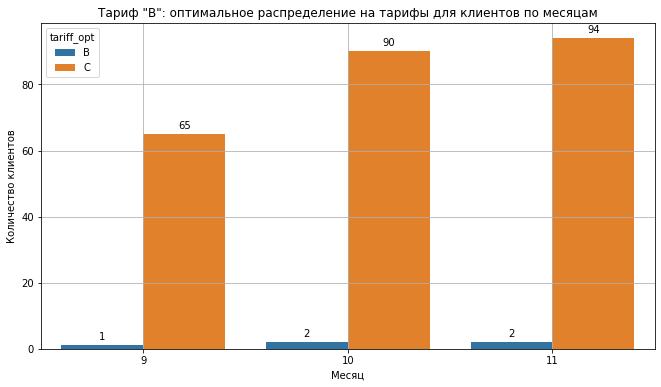

In [152]:
# Построим график
plt.figure(figsize=(11, 6))
splot=sns.barplot(x="month_date", y="user_id", hue="tariff_opt", data=user_B_opt)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Тариф "B": оптимальное распределение на тарифы для клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.grid()
plt.show()

Видно, что клиентам тарифа "В" также выгодно переходить на тариф "С". Причем на тариф "А" не выгодно переходить совсем.

In [153]:
# Посчитаем доход в настоящее время за 3 месяца
exmp.query('tariff_plan == "B" & month_date != 8')['revenue_B'].sum()

642994.0

In [154]:
# Посчитаем доход, если бы всех клиентов тарифа "B" перевели на оптимальные для них тарифы
user_B_opt.query('tariff_opt != "B"')['revenue_opt'].sum()

373245.1

In [155]:
(exmp.query('tariff_plan == "B" & month_date != 8')['revenue_B'].sum()) - \
    user_B_opt.query('tariff_opt != "B"')['revenue_opt'].sum()

269748.9

##### Промежуточный вывод:
* Если всех клиентов тарифа "B" перевести на оптимальный для них тариф, то компания потеряет примерно 270 000 рублей за 3 месяца

In [156]:
# Посчитаем также среднее количество минут на исходящих звонках
minut_B_mean = exmp.query('tariff_plan == "B" & month_date != 8')['sum_out_network'].mean()
minut_B_mean

516.488188976378

In [157]:
# Посчитаем, если мы переведем не всех клиентов, а только тех, у кого количество внешних звонков на тарифе меньше среднего
user_B_new = exmp.query('tariff_plan == "B" & sum_out_network < @minut_B_mean')

In [158]:
user_B_new.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money,revenue_A,revenue_B,revenue_C,current_tariff_revenue,revenue_opt,tariff_opt,delta
27,166428,B,8,1,0,0,2000,0.15,0.50,"2,100.00","5,100.00","2,100.00","1,100.00","2,100.00","1,100.00",C,"1,000.00"
28,166428,B,9,1,0,0,2000,0.15,0.50,"2,100.00","5,100.00","2,100.00","1,100.00","2,100.00","1,100.00",C,"1,000.00"
29,166428,B,10,3,0,0,2000,0.15,0.50,"2,300.00","5,300.00","2,300.00","1,300.00","2,300.00","1,300.00",C,"1,000.00"
30,166428,B,11,1,0,0,2000,0.15,0.50,"2,100.00","5,100.00","2,100.00","1,100.00","2,100.00","1,100.00",C,"1,000.00"
38,166485,B,8,3,0,80,2000,0.15,0.50,"2,340.00","5,332.00","2,340.00","1,356.00","2,340.00","1,356.00",C,984.00


In [159]:
# Посчитаем доход с этих клиентов
user_B_new.query('tariff_opt != "B"')['revenue_opt'].sum()

292359.9

In [160]:
# Разница
(exmp.query('tariff_plan == "B" & month_date != 8')['revenue_B'].sum()) - \
    (user_B_new.query('tariff_opt != "B"')['revenue_opt'].sum())

350634.1

##### Вывод:
* Если всех клиентов тарифа "B" перевести на оптимальный для них тариф, то компания потеряет примерно 270 000 рублей за 3 месяца
* Если на оптимальный тариф перевести не всех клиентов, а только тех, количество звонков которых меньше среднего, то компания потеряет примерно 350 000 рублей за 3 месяца

#### Тариф "С":

In [161]:
# Посчитаем количество клиентов по месяцам на тарифе и доход, если бы клиент был на оптимальном тарифе
user_C_opt = exmp.query('tariff_plan == "C" & month_date != 8')
user_C_opt = user_C_opt.groupby(
    ['month_date', 'tariff_opt'])['user_id', 'revenue_opt'].agg({'user_id':'count', 'revenue_opt':'sum'}).reset_index()
user_C_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,B,2,"13,601.00"
1,9,C,86,"116,819.40"
2,10,B,2,"15,266.00"
3,10,C,146,"199,244.70"
4,11,B,1,"7,120.50"
5,11,C,134,"194,195.40"


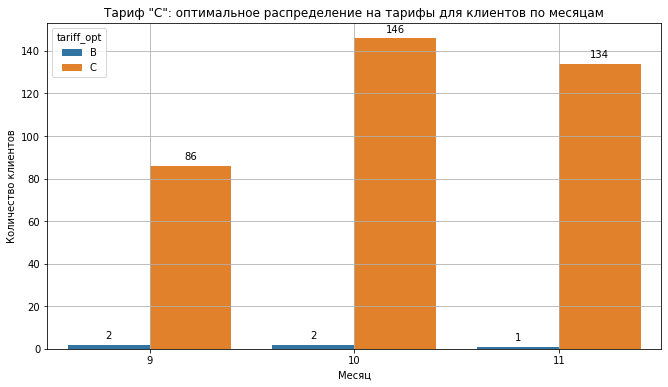

In [162]:
# Построим график
plt.figure(figsize=(11, 6))
splot=sns.barplot(x="month_date", y="user_id", hue="tariff_opt", data=user_C_opt)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Тариф "C": оптимальное распределение на тарифы для клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.grid()
plt.show()

А вот клиентам тарифа "С" выгоднее оставаться на своем тарифе. Лишь 1-2 человекам в месяц выгоднее сменить тариф

In [163]:
# Посчитаем доход в настоящее время за 3 месяца
exmp.query('tariff_plan == "C" & month_date != 8')['revenue_C'].sum()

550522.0

In [164]:
# Посчитаем доход, если бы всех клиентов тарифа "C" перевели на оптимальные для них тарифы
user_C_opt.query('tariff_opt != "C"')['revenue_opt'].sum()

35987.5

In [165]:
# Разница
(exmp.query('tariff_plan == "C" & month_date != 8')['revenue_C'].sum()) - \
    (user_C_opt.query('tariff_opt != "C"')['revenue_opt'].sum())

514534.5

##### Выводы:
* Тариф "С" - самый оптимальный для клиентов. Если абоненты перейдут на оптимальный для них тариф, то компания потеряет совсем немного - около 36 000 рублей

#### Посчитаем проценты клиентов на тарифах, которые не переплачивают:

In [166]:
user_A_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,A,1,"38,830.00"
1,9,B,1,"16,987.50"
2,9,C,17,"22,532.60"
3,10,A,2,"66,148.00"
4,10,B,2,"20,500.50"
5,10,C,29,"51,847.30"
6,11,A,1,"36,337.60"
7,11,B,3,"35,502.00"
8,11,C,26,"44,088.90"


In [167]:
# Будем считать данные за 3 месяца: клиентов на тарифе "А" поделим на сумму всех остальных клиентов
overpayment_A = (user_A_opt.query('tariff_opt == "A"')['user_id'].sum()) / \
    (user_A_opt.query('tariff_opt != "A"')['user_id'].sum())

In [168]:
# Для красивого отображения округляем до двух знаков и меняем тип
overpayment_A = round(overpayment_A,2).astype(str)
display('На тарифе "А" не переплачивают: ' + overpayment_A + '%')

'На тарифе "А" не переплачивают: 0.05%'

In [169]:
user_B_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,B,1,"9,063.50"
1,9,C,65,"91,444.90"
2,10,B,2,"14,910.00"
3,10,C,90,"134,027.00"
4,11,B,2,"14,274.00"
5,11,C,94,"147,773.20"


In [170]:
# Будем считать данные за 3 месяца: клиентов на тарифе "B" поделим на сумму всех остальных клиентов
overpayment_B = (user_B_opt.query('tariff_opt == "B"')['user_id'].sum()) / \
    (user_B_opt.query('tariff_opt != "B"')['user_id'].sum())

In [171]:
# Для красивого отображения округляем до двух знаков и меняем тип
overpayment_B = round(overpayment_B,2).astype(str)
display('На тарифе "B" не переплачивают: ' + overpayment_B + '%')

'На тарифе "B" не переплачивают: 0.02%'

In [172]:
user_C_opt

,month_date,tariff_opt,user_id,revenue_opt
0,9,B,2,"13,601.00"
1,9,C,86,"116,819.40"
2,10,B,2,"15,266.00"
3,10,C,146,"199,244.70"
4,11,B,1,"7,120.50"
5,11,C,134,"194,195.40"


In [173]:
# Будем считать данные за 3 месяца: клиентов на тарифе "B" поделим на сумму всех остальных клиентов
overpayment_C = (user_C_opt.query('tariff_opt == "C"')['user_id'].sum()) / \
    (user_C_opt.query('tariff_opt != "C"')['user_id'].sum())

In [174]:
# Для красивого отображения округляем до двух знаков и меняем тип
overpayment_C = round(overpayment_C,2).astype(str)
display('На тарифе "C" не переплачивают: ' + overpayment_C + '%')

'На тарифе "C" не переплачивают: 73.2%'

#### Выводы:
* На тарифе "А" и "В" за 3 месяца находятся на оптимальном тарифе меньше 1% пользователей;
* На тарифе "С" находятся на оптимальном тарифе примерно 73% пользователей;

#### Общие выводы:
* Всего активных клиентов на тарифах: в сентябре - 173, в октябре - 273, в ноябре - 261. Из них:
    - в сентябре: тариф "А" - 19 клиентов (11%), тариф "В" - 66 клиентов (38%), тариф "С" - 88 клиентов (51%);
    - в октябре: тариф "А" - 33 клиента (12%), тариф "В" - 92 клиентов (34%), тариф "С" - 148 клиентов (54%);
    - в ноябре: тариф "А" - 30 клиентов (11%), тариф "В" - 96 клиентов (37%), тариф "С" - 135 клиентов (52%);
* Из них находятся на оптимальном тарифе:
    - на тарифе "А" - менее 1% пользователей;
    - на тарифе "В" - менее 1% пользователей;
    - на тарифе "С" - около 73% пользователей
* Клиентам, которые переплачивают (в основном):
    - с тарифа "А" перейти на тариф "С";
    - с тарифа "В" перейти на тариф "С"
* В случае перехода компания потеряет (без учета дохода на других тарифах):
    - при переходе с тарифа "А" на выгодный тариф компания потеряет около 431 000 рублей;
    - при переходе с тарифа "В" на выгодный тариф компания потеряет около 270 000 рублей;
    - при переходе с тарифа "С" на выгодный тариф компания потеряет около 35 000 рублей
    
    

# Шаг 4. Проверка гипотез:<a id="step5"></a>   
</div>

##### Первая гипотеза:
Нулевая гипотеза Hо: "Средний доход компании с тарифа "А" и тарифа "В" не различается". 
Альтернативная гипотеза Н1: "Средний доход компании с тарифа "А" и тарифа "В" различается".

Проверим на выбросы:

In [175]:
income.head()

,user_id,tariff_plan,month_date,operator_id,sum_in_network,sum_out_network,tariff_price,price_in_network,price_out_network,total_money
0,166377,B,8,5,0,1301,2000,0.15,0.50,"3,150.50"
1,166377,B,9,4,0,1764,2000,0.15,0.50,"3,282.00"
2,166377,B,10,5,0,1654,2000,0.15,0.50,"3,327.00"
3,166377,B,11,4,0,1590,2000,0.15,0.50,"3,195.00"
4,166391,C,8,2,0,0,1000,0.30,0.70,"1,200.00"


<AxesSubplot:>

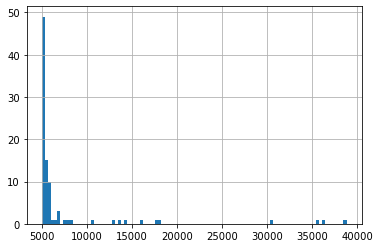

In [176]:
income[income['tariff_plan'] == "A"]['total_money'].hist(bins=100)

Видим много выбросов, удалим их, чтобы было более-менее нормальное распределение:

In [177]:
income_A_hyp = income.query('tariff_plan == "A" & total_money < 6000')

<AxesSubplot:>

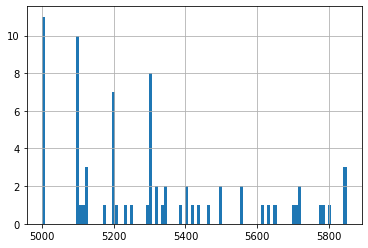

In [178]:
income_A_hyp['total_money'].hist(bins=100)

То же самое проделаем с тарифом "В":

<AxesSubplot:>

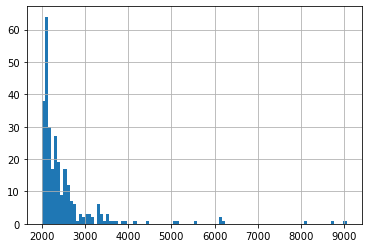

In [179]:
income[income['tariff_plan'] == "B"]['total_money'].hist(bins=100)

In [180]:
income_B_hyp = income.query('tariff_plan == "B" & total_money < 3000')

<AxesSubplot:>

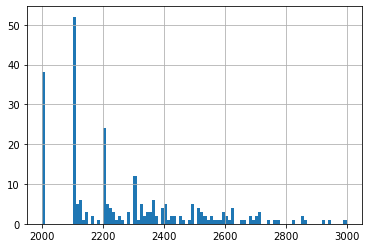

In [181]:
income_B_hyp['total_money'].hist(bins=100)

In [182]:
# Тест двусторонний, т.к. отклонение может быть в большую или меньшую сторону
alpha = .05
results = st.ttest_ind(income_A_hyp['total_money'], income_B_hyp['total_money'])

display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

3.079954221545792e-244

'Отвергаем нулевую гипотезу'

Нулевая гипотеза отвергнута, следовательно, нельзя утверждать, что средний доход компании  тарифа "А" и тарифа "В" не различается"

##### Вторая гипотеза:
Сформулируем нулевую гипотезу Hо: "Выручка на трех тарифах одинаковая". 
Альтернативная гипотеза Н1: "Выручка на трех тарифах не одинаковая"

In [183]:
values1 = exmp.query('tariff_plan == "A" & total_money < 30000')['total_money']

In [184]:
values2 = exmp.query('tariff_plan == "B"')['total_money']

In [185]:
values3 = exmp.query('tariff_plan == "C"')['total_money']

In [186]:
alpha = .05 

results = st.ttest_ind(
    values1,
    values3) # проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)#  p-значение

if results.pvalue < alpha: # сравним получившееся p-значение с заданным уровнем статистической значимости :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1597558197772227e-107
Отвергаем нулевую гипотезу


In [187]:
alpha = .05 

results = st.ttest_ind(
    values1,
    values2) # проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)#  p-значение

if results.pvalue < alpha: # сравним получившееся p-значение с заданным уровнем статистической значимости :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.725203642710236e-62
Отвергаем нулевую гипотезу


In [188]:
alpha = .05 

results = st.ttest_ind(
    values2,
    values3) # проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)#  p-значение

if results.pvalue < alpha: # сравним получившееся p-значение с заданным уровнем статистической значимости :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.1114009361370717e-43
Отвергаем нулевую гипотезу


При сравнении значений попарно видим, что везде нулевая гипотеза отвергнута. Следовательно, выручка на трех тарифах не одинаковая

# Шаг 5. Формирование выводов и предположение оптимизации потерь компании:<a id="step6"></a>   
</div>

Мы проанализировали расходы клиентов на трех тарифах, получили данные о выручке за отчетный период, посчитали, что будет, если клиентов перевести на оптимальные для них тарифы.

#### Выводы:
* Тариф "В" самый массовый и приносит больше денег. Но пользователям выгоднее переходить на тариф "С".
* Тариф "А" самый дорогой, но приносит значительный доход
* Тариф "С" самый оптимальный для пользователей

#### Рекомендации для менеджеров по работе с клиентами:
* Рекомендовать клиентам переходить с тарифа "А" на тариф "В" если их траты меньше 10 000 рублей;
* Рекомендовать клиентам переходить с тарифа "В" на тариф "С" если их траты меньше 4350 рублей;

# Материалы:<a id="step7"></a>   
</div>




[Дашборд] https://public.tableau.com/app/profile/shingarov.timofey/viz/Telecom_16581464574510/Dashboard1?publish=yes

[Презентация] https://disk.yandex.ru/i/W0D0uziCUB4QPg